In [5]:
import numpy as np
import pandas as pd
import statsmodels.tsa.api as sm
from statsmodels.tsa.api import VAR
import matplotlib.pyplot as plt
import warnings
from sklearn import preprocessing
from sklearn.metrics import mean_squared_error
import datetime
import os
warnings.filterwarnings("ignore")

def tsplot(y, lags=50, figsize=(10, 8), style='bmh'):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))    
        y.plot(ax=ts_ax)
        p_value = sm.adfuller(y)[1]
        ts_ax.set_title('Time Series Analysis Plots\n Dickey-Fuller: p={0:.5f}'.format(p_value))
        sm.graphics.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        plt.tight_layout()
    return

def write_results(file_name, results, columns):
    with open(file_name,"w") as fw:
        print(results.summary(), file=fw)
        fw.write("================test_whiteness================\n")
        print(results.test_whiteness(nlags=20), file=fw)
        fw.write("================results.roots()================\n")
        for root in results.roots:
            fw.write(str(root)+",")
        fw.write("\n================is_stable================\n")
        fw.write(str(results.is_stable()))
        fw.write("\n================granger causality================\n")
        for V1 in columns:
            for V2 in columns:
                fw.write("Granger test: "+V2+"-->"+V1+"\n")
                print(results.test_causality(V1, [V2],kind='f').summary(), file=fw)
                fw.write("\n")

        fw.write("\n================long_run effects================\n")
        for effect in results.long_run_effects():
            fw.write(str(effect)+",")
        fw.write("\n================FEVD values================\n")
        from contextlib import redirect_stdout
        with redirect_stdout(fw):
            print(results.fevd(20).summary())

def structural_analyses(file_name, results, lag=20):
    # impulse response analyses
    irf = results.irf(lag)
    irf.plot(orth=False)
    plt.savefig(file_name+"_irf_noorth.png")
    # irf.plot(impulse='V1', response="V2")
    irf.plot_cum_effects(orth=False)
    plt.savefig(file_name+"_irf_cum_noorth.png")
    results.long_run_effects()

    # forecast error decomposition
    results.fevd(lag).plot()
    plt.savefig(file_name+"_fevd.png")
    

In [6]:
# read csv file    
df = pd.read_csv("data.csv")
# convert to date format
df['date'] = pd.to_datetime(df['date'], format = "%Y-%m-%d").dt.date
# set date as index
df.index = df['date']
df.drop(['Unnamed: 0', 'date'], axis=1, inplace=True)
print(df)


                   USD           BTC          ETH       XLM      USDT  \
date                                                                    
2017-04-03  100.540001   1143.810059    44.356400  0.003124  0.999752   
2017-04-04  100.540001   1133.250000    44.641899  0.003046  1.000020   
2017-04-05  100.559998   1124.780029    45.304001  0.003131  1.000110   
2017-04-06  100.669998   1182.680054    43.242100  0.002824  0.999939   
2017-04-07  101.180000   1176.900024    42.162601  0.002767  0.999873   
...                ...           ...          ...       ...       ...   
2021-03-30   93.300003  58917.691410  1846.033691  0.405941  1.000896   
2021-03-31   93.230003  58918.832030  1918.362061  0.410898  1.000020   
2021-04-01   92.930000  59095.808590  1977.276855  0.432512  1.000464   
2021-04-02   93.022003  59384.312500  2143.225586  0.446585  1.000576   
2021-04-03   93.022003  59457.714840  2096.958008  0.450178  1.001258   

                NANO  
date                  
2017

                   USD           BTC       XLM
date                                          
2017-04-03  100.540001   1143.810059  0.003124
2017-04-04  100.540001   1133.250000  0.003046
2017-04-05  100.559998   1124.780029  0.003131
2017-04-06  100.669998   1182.680054  0.002824
2017-04-07  101.180000   1176.900024  0.002767
...                ...           ...       ...
2021-03-30   93.300003  58917.691410  0.405941
2021-03-31   93.230003  58918.832030  0.410898
2021-04-01   92.930000  59095.808590  0.432512
2021-04-02   93.022003  59384.312500  0.446585
2021-04-03   93.022003  59457.714840  0.450178

[1462 rows x 3 columns]


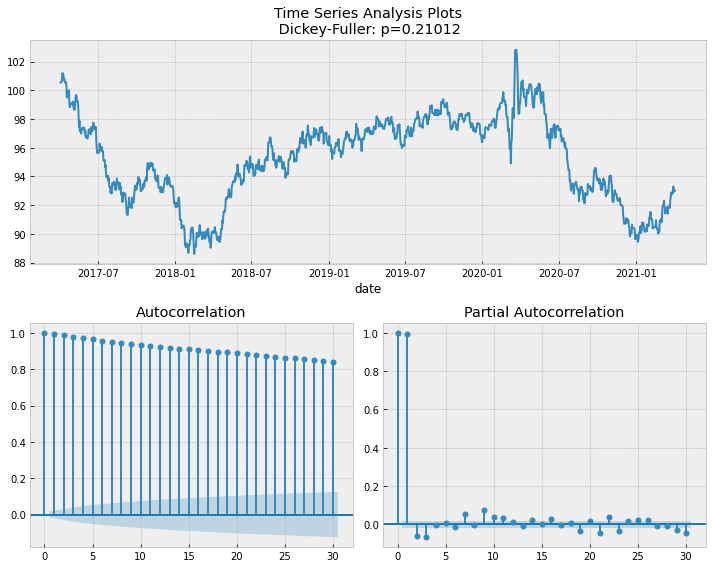

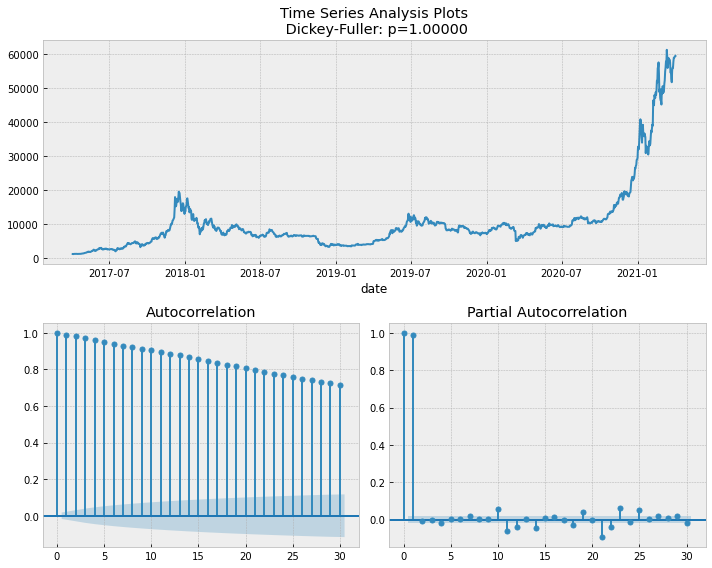

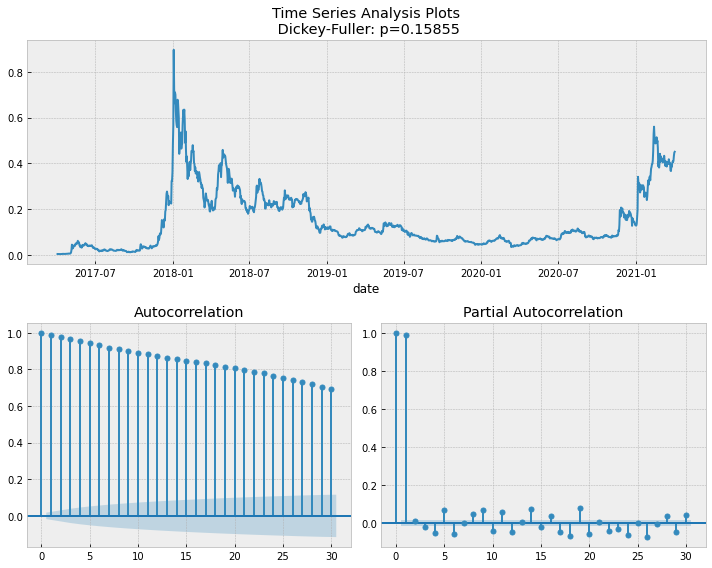

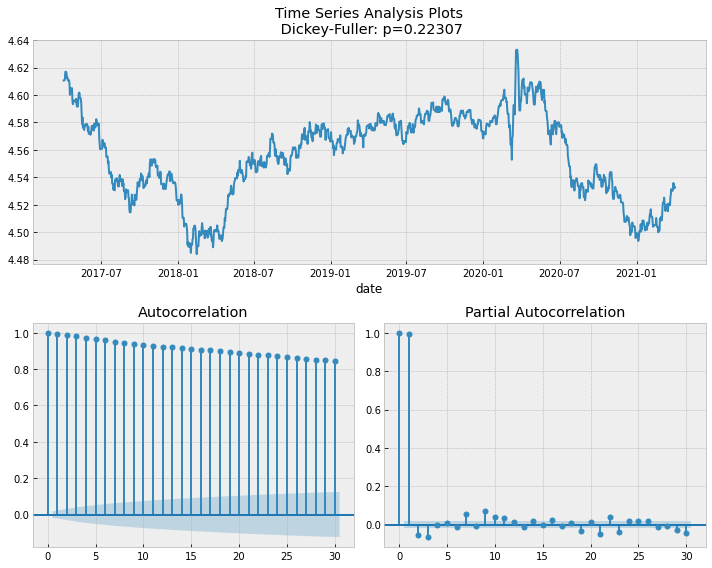

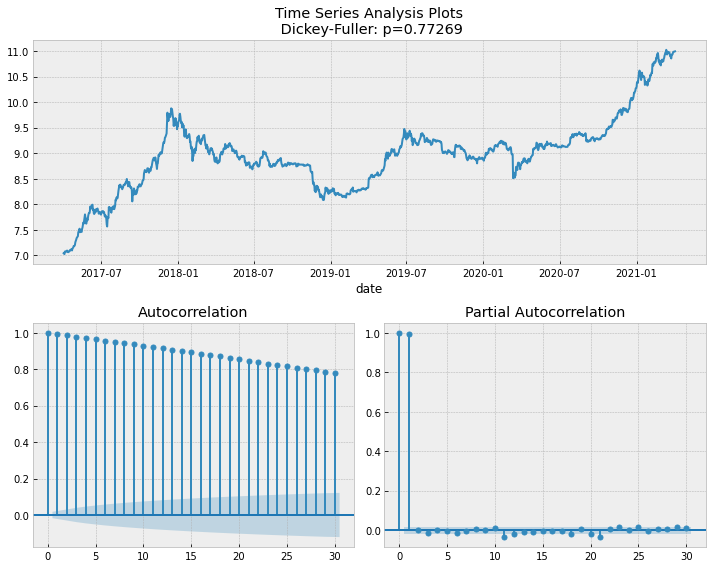

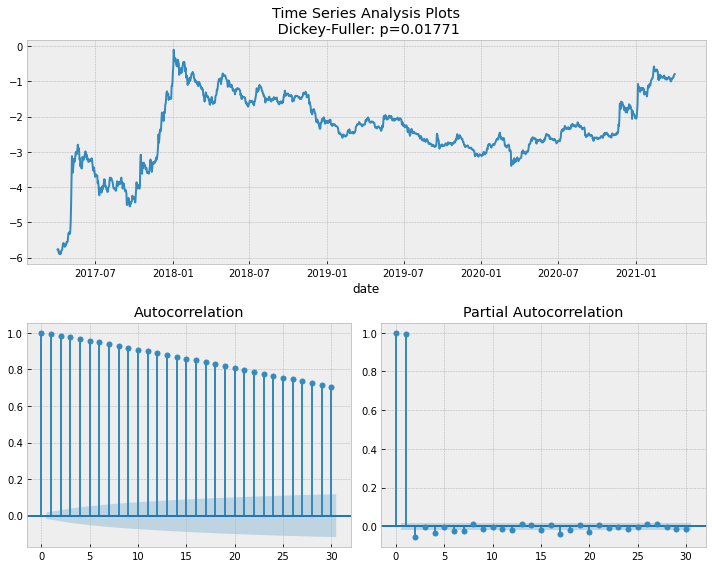

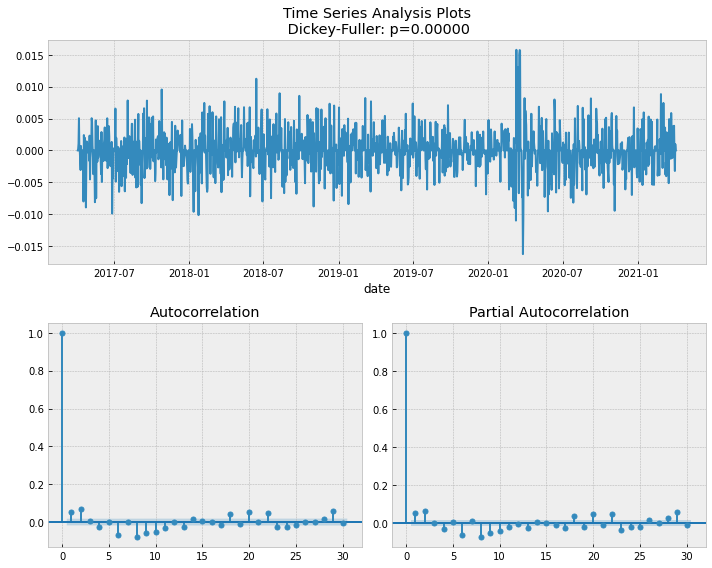

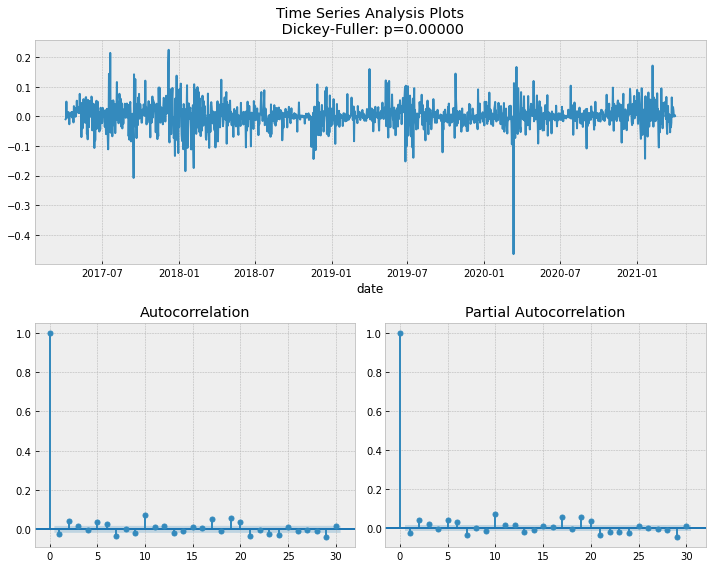

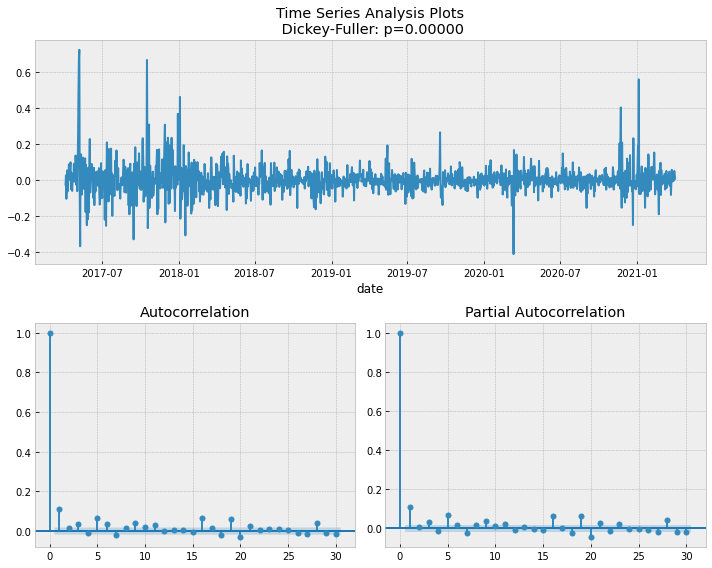

 VAR Order Selection (* highlights the minimums)  
       AIC         BIC         FPE         HQIC   
--------------------------------------------------
0       -23.19     -23.18*   8.444e-11      -23.19
1       -23.22      -23.18   8.197e-11     -23.21*
2      -23.24*      -23.16  8.110e-11*      -23.21
3       -23.23      -23.12   8.154e-11      -23.19
4       -23.22      -23.08   8.208e-11      -23.17
5       -23.23      -23.05   8.194e-11      -23.16
6       -23.23      -23.02   8.158e-11      -23.15
7       -23.23      -22.98   8.189e-11      -23.14
8       -23.22      -22.95   8.194e-11      -23.12
9       -23.22      -22.91   8.222e-11      -23.11
10      -23.22      -22.88   8.252e-11      -23.09
11      -23.21      -22.84   8.291e-11      -23.07
12      -23.21      -22.81   8.281e-11      -23.06
13      -23.21      -22.77   8.288e-11      -23.05
14      -23.20      -22.73   8.369e-11      -23.03
15      -23.20      -22.70   8.379e-11      -23.01
16      -23.20      -22.66   8.

In [7]:
# Tether Case
id = 'stella'
data = df.drop(['USDT', 'ETH','NANO'], axis=1, inplace = False)
print(data)

focused_columns = ["USD", "BTC", "XLM"]

if not os.path.exists(id):
    os.makedirs(id)

# see original plots of all products
for column in focused_columns:
    tsplot(data[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_'+column+'.png')
    plt.show()
    plt.close()
    
# log transformation
data_log = data.copy()
for column in focused_columns:
    data_log[column] = np.log(data[column]) 
    tsplot(data_log[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_log_'+column+'.png')
    plt.show()
    plt.close()

# first order differencing
data_diff = data_log.diff().dropna()
for column in focused_columns:
    tsplot(data_diff[column], lags = 30)
    plt.savefig(str(id)+'/tsplot_diff_'+column+'.png')
    plt.show()
    plt.close()

# modelling using VAR for analysis
model = VAR(data_diff.dropna())
print(model.select_order(20).summary())
selected_orders = model.select_order(20).selected_orders
print(selected_orders)

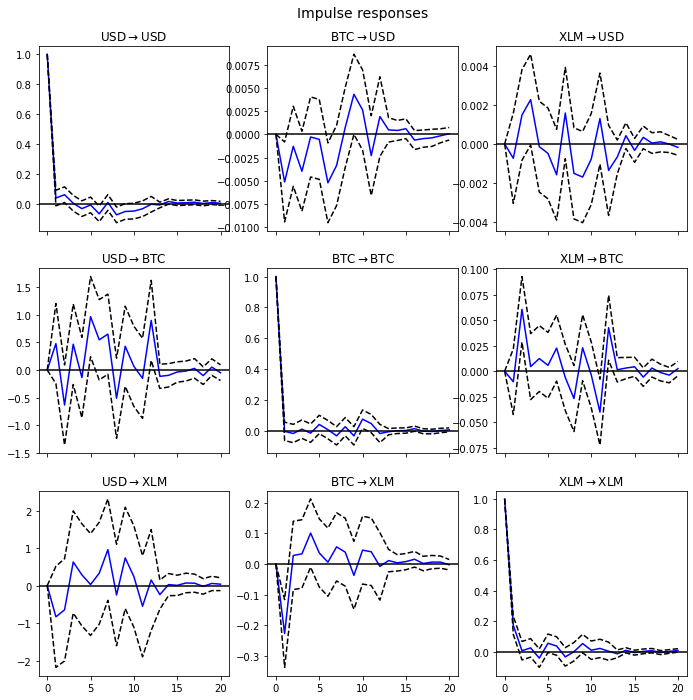

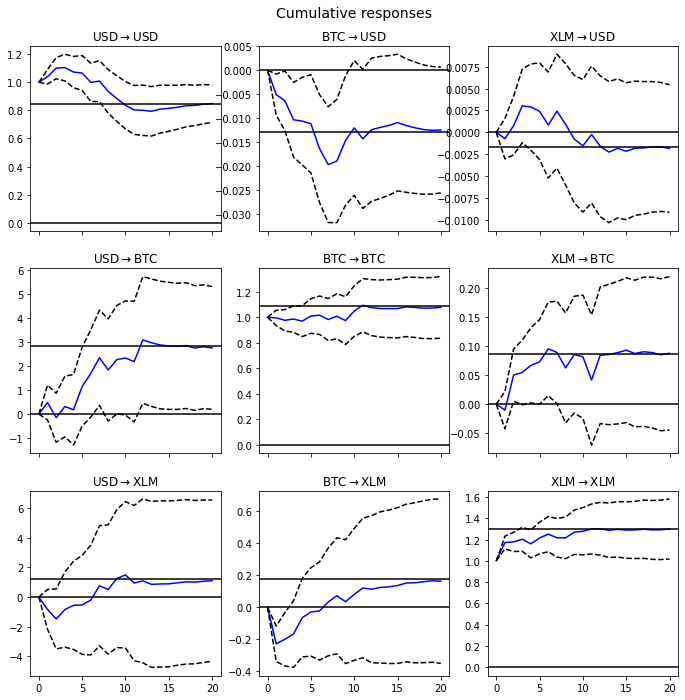

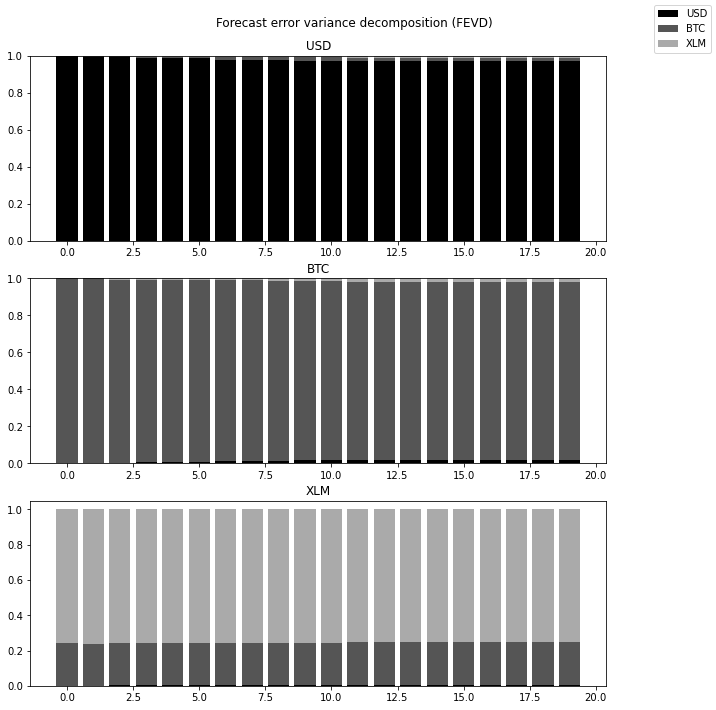

In [8]:
# order 12 is the best lag order
order = 12
results = model.fit(order, trend="c")
results_file = f"{id}/results_lag{order}.txt" 
structural_file = f"{id}/lag{order}"
columns = data.columns.values.tolist()
write_results(results_file, results, columns)
structural_analyses(structural_file, results, 20)